In [39]:
import pandas as pd
import ast
import random
import json
import cv2
import matplotlib.pyplot as plt


class BoundingBox:
    def __init__(self, x, y, width, height, depth):
        self.x = int(x)
        self.y = int(y)
        self.width = int(width)
        self.height = int(height)
        self.class_name = None
        self.depth = depth
        self.children = []
        self.scrollable = False
        self.id = None

    def add_child(self, child):
        self.children.append(child)
    def area(self):
        return self.width * self.height

    def intersects(self, other):
        return not (self.x + self.width <= other.x or self.x >= other.x + other.width or 
                    self.y + self.height <= other.y or self.y >= other.y + other.height)
def calculate_iou(bbox1, bbox2):
    """
    Calculate the Intersection over Union (IOU) of two bounding boxes.

    Parameters:
    bbox1 (BoundingBox): The first bounding box.
    bbox2 (BoundingBox): The second bounding box.

    Returns:
    float: The IOU value.
    """
    # Calculate the coordinates of the intersection rectangle
    x1 = max(bbox1.x, bbox2.x)
    y1 = max(bbox1.y, bbox2.y)
    x2 = min(bbox1.x + bbox1.width, bbox2.x + bbox2.width)
    y2 = min(bbox1.y + bbox1.height, bbox2.y + bbox2.height)

    # Calculate the area of intersection rectangle
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate the area of both bounding boxes
    bbox1_area = bbox1.width * bbox1.height
    bbox2_area = bbox2.width * bbox2.height

    # Calculate the union area
    union_area = bbox1_area + bbox2_area - intersection_area
    if union_area == 0:
        return 0
    # Calculate the IOU
    iou = intersection_area / union_area

    return iou


def recu_check_multi_children(tree_root):
    if 'children' in tree_root:
        if len(tree_root['children']) > 1:
            return True
        for i in range(len(tree_root['children'])):
            if recu_check_multi_children(tree_root['children'][i]):
                return True
    return False

def recu_build_bbox_tree(tree_root, depth):


    bbox_subtree = BoundingBox(tree_root['bounds']['left'], tree_root['bounds']['top'], tree_root['bounds']['right'] - tree_root['bounds']['left'], tree_root['bounds']['bottom'] - tree_root['bounds']['top'], depth)
    # bbox.scrollable = tree_root['scrollable']
    bbox_subtree.class_name = tree_root['class_name']
    bbox_subtree.id = tree_root['index']
    all_bbox.append(bbox_subtree)
    x, xw, y, yh = tree_root['bounds']['left'], tree_root['bounds']['right'], tree_root['bounds']['top'], tree_root['bounds']['bottom']
    w = xw - x
    h = yh - y
    
    if 'children' in tree_root:
        for i in range(len(tree_root['children'])):
            child_subtree = recu_build_bbox_tree(tree_root['children'][i], depth+1)
            if child_subtree:
                bbox_subtree.add_child(child_subtree)
            else:
                continue
            if calculate_iou(child_subtree, bbox_subtree) > IOU_THRESHOLD:
                if any([recu_check_multi_children(t_r) for t_r in tree_root['children']]):
                    for b in dup_bbox:
                        if calculate_iou(b, bbox_subtree) > IOU_THRESHOLD:
                            if b.area() < bbox_subtree.area():
                                dup_bbox.remove(b)
                                dup_bbox.append(bbox_subtree)
                            break
                    else:
                        dup_bbox.append(bbox_subtree)
            # else:

            #     for b in small_bbox:
            #         if calculate_iou(b, bbox_subtree) > IOU_THRESHOLD:
            #             if b.area() < bbox_subtree.area():
            #                 small_bbox.remove(b)
            #                 small_bbox.append(bbox_subtree)
            #             break
            #     else:
            #         small_bbox.append(bbox_subtree)
            
        return bbox_subtree
    else:
        for b in small_bbox:
            if calculate_iou(b, bbox_subtree) > IOU_THRESHOLD:
                if b.area() < bbox_subtree.area():
                    small_bbox.remove(b)
                    small_bbox.append(bbox_subtree)
                break
        else:
            small_bbox.append(bbox_subtree)
        return bbox_subtree
    
def recu_get_leafs(tree_root_1, depth, root=None,color=None):
    leaf_root_pair = []
    for i in range(len(tree_root_1)):
        
        if root==None:
            current_root = tree_root_1[i]
            color = random_color()
        else:
            current_root = root
            
        if 'children' in tree_root_1[i]:
            leaf_root_pair += recu_get_leafs(tree_root_1[i]['children'], depth+1, current_root, color)
        
        leaf_root_pair.append([tree_root_1[i], current_root, color,depth])
    return leaf_root_pair
    

def random_color():
    r = random.randrange(256)  # Random value for red (0-255)
    g = random.randrange(256)  # Random value for green (0-255)
    b = random.randrange(256)  # Random value for blue (0-255)
    return (r,g,b)  # Return the color in hexadecimal format

        

        
def optimize_bounding_boxes(node, selected_boxes, current_area, current_depth_sum, memo):
    if node in memo:
        return memo[node]

    # Option 1: Include this box if it does not intersect with already selected ones
    if  (all(not node.intersects(box) for box in selected_boxes) and node.width * node.height <  0.95*canvas_height * canvas_width):
        new_selected_boxes = selected_boxes + [node]
        new_area = current_area + node.area()
        new_depth_sum = current_depth_sum + node.depth
        best_area_incl, best_boxes_incl = current_area, selected_boxes
        if node.children:
            # If this node is included, do not consider its children since they would overlap
            best_area_incl, best_boxes_incl = new_area, new_selected_boxes
        else:
            # Recur for the same node assuming it's included (to keep the recursion valid)
            best_area_incl, best_boxes_incl = optimize_bounding_boxes(node, new_selected_boxes, new_area, new_depth_sum, memo)
    else:
        best_area_incl, best_boxes_incl = current_area, selected_boxes

    # Option 2: Exclude this box, recursively check each child independently
    best_area_excl, best_boxes_excl = current_area, selected_boxes
    temp_area, temp_boxes = current_area, selected_boxes.copy()
    for child in node.children:
        new_area, new_boxes = optimize_bounding_boxes(child, temp_boxes, temp_area, current_depth_sum, memo)
        if new_area > temp_area:
            temp_area = new_area
            temp_boxes = new_boxes

    # Choose the best option between including this node or not
    if best_area_incl >= temp_area:
        
        result = (best_area_incl, best_boxes_incl)
    else:
        result = (temp_area, temp_boxes)

    memo[node] = result
    return result



In [40]:
import glob
json_files = glob.glob('/data1/yue/ScreenReaderData/screendata/*/*.json', recursive=True)
# json_files = glob.glob('/Users/fanyue/ScreenReaderData/web/*.json', recursive=True)


In [41]:
json_files

['/data1/yue/ScreenReaderData/screendata/2655_8/task2655_3.json',
 '/data1/yue/ScreenReaderData/screendata/2655_8/task2655_5.json',
 '/data1/yue/ScreenReaderData/screendata/2655_8/task2655_4.json',
 '/data1/yue/ScreenReaderData/screendata/2655_8/task2655_1.json',
 '/data1/yue/ScreenReaderData/screendata/2655_8/task2655_2.json',
 '/data1/yue/ScreenReaderData/screendata/2562_0/task2562_5.json',
 '/data1/yue/ScreenReaderData/screendata/2562_0/task2562_1.json',
 '/data1/yue/ScreenReaderData/screendata/2562_0/task2562_6.json',
 '/data1/yue/ScreenReaderData/screendata/2562_0/task2562_4.json',
 '/data1/yue/ScreenReaderData/screendata/2562_0/task2562_9.json',
 '/data1/yue/ScreenReaderData/screendata/2562_0/task2562_2.json',
 '/data1/yue/ScreenReaderData/screendata/2562_0/task2562_7.json',
 '/data1/yue/ScreenReaderData/screendata/2562_0/task2562_3.json',
 '/data1/yue/ScreenReaderData/screendata/2562_0/task2562_8.json',
 '/data1/yue/ScreenReaderData/screendata/2693_0/task2693_1.json',
 '/data1/y

In [42]:
IOU_THRESHOLD = 0.8

/data1/yue/ScreenReaderData/screendata/2655_8/task2655_3.json
0 2187 1440 193 277920 android.widget.LinearLayout 21
48 2386 1344 144 193536 android.widget.FrameLayout 44
0 2380 1440 180 259200 android.widget.FrameLayout 42
0 2127 1440 433 623520 android.widget.FrameLayout 17
0 0 1440 2560 3686400 android.view.ViewGroup 7
36 160 1368 144 196992 android.widget.FrameLayout 75
0 0 1440 340 489600 android.widget.FrameLayout 69


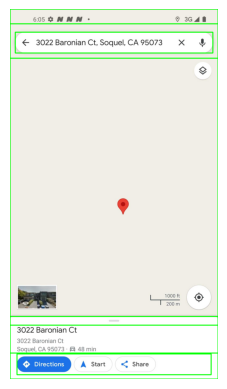

/data1/yue/ScreenReaderData/screendata/2655_8/task2655_5.json
0 0 1440 2560 3686400 android.widget.LinearLayout 11
/data1/yue/ScreenReaderData/screendata/2655_8/task2655_4.json
0 807 1440 300 432000 android.widget.FrameLayout 46
0 1867 1440 144 207360 android.widget.LinearLayout 153
0 807 1440 1753 2524320 android.widget.LinearLayout 42
0 0 1440 2560 3686400 android.view.ViewGroup 7
0 0 1440 304 437760 android.widget.FrameLayout 218
/data1/yue/ScreenReaderData/screendata/2655_8/task2655_1.json
0 0 1440 2560 3686400 android.view.ViewGroup 7
36 160 1368 144 196992 android.widget.FrameLayout 21
0 0 1440 322 463680 android.widget.FrameLayout 15
0 322 1440 144 207360 android.widget.LinearLayout 50
0 2401 1440 159 228960 android.widget.LinearLayout 90
/data1/yue/ScreenReaderData/screendata/2655_8/task2655_2.json
0 322 533 182 97006 android.widget.LinearLayout 17
533 322 536 182 97552 android.widget.LinearLayout 29
0 322 1393 182 253526 android.widget.LinearLayout 14
0 711 1380 122 168360 and

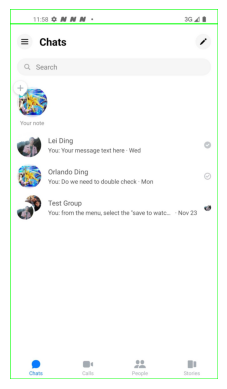

/data1/yue/ScreenReaderData/screendata/1586_3/task1586_4.json
0 136 1440 168 241920 android.widget.LinearLayout 37
0 136 1440 1566 2255040 android.widget.LinearLayout 36
/data1/yue/ScreenReaderData/screendata/619_0/task619_1.json
0 2392 1440 168 241920 android.widget.FrameLayout 72
0 0 1440 2560 3686400 android.widget.LinearLayout 1
/data1/yue/ScreenReaderData/screendata/619_0/task619_2.json
0 765 1416 198 280368 android.view.View 29
0 0 1440 2560 3686400 android.widget.LinearLayout 1
/data1/yue/ScreenReaderData/screendata/619_0/task619_3.json
0 0 1440 2560 3686400 android.widget.LinearLayout 1
/data1/yue/ScreenReaderData/screendata/2541_3/task2541_7.json
/data1/yue/ScreenReaderData/screendata/2541_3/task2541_3.json
0 0 1440 2560 3686400 android.view.ViewGroup 7
36 160 1368 144 196992 android.widget.FrameLayout 21
0 0 1440 322 463680 android.widget.FrameLayout 15
0 2000 1440 160 230400 android.widget.LinearLayout 55
0 1952 1440 608 875520 android.widget.FrameLayout 53
0 1784 1440 776 1

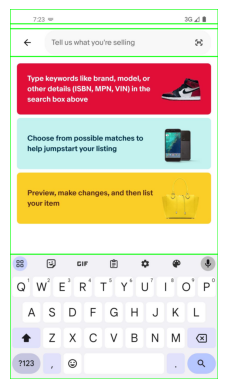

/data1/yue/ScreenReaderData/screendata/1981_6/task1981_6.json
0 136 1440 192 276480 android.widget.LinearLayout 14
0 328 1440 1368 1969920 android.widget.ScrollView 29
0 0 1440 2560 3686400 android.widget.FrameLayout 12
/data1/yue/ScreenReaderData/screendata/1981_6/task1981_8.json
0 136 1440 192 276480 android.widget.LinearLayout 14
0 0 1440 2560 3686400 android.widget.FrameLayout 12
/data1/yue/ScreenReaderData/screendata/1981_6/task1981_2.json
0 136 1440 192 276480 android.widget.LinearLayout 8
0 1096 1440 984 1416960 android.widget.LinearLayout 33
0 2320 1440 240 345600 android.widget.FrameLayout 69
0 0 1440 2560 3686400 android.widget.LinearLayout 1
/data1/yue/ScreenReaderData/screendata/1981_6/task1981_12.json
0 136 1440 192 276480 android.widget.LinearLayout 8
48 849 1392 447 622224 androidx.recyclerview.widget.RecyclerView 30
24 1392 1416 816 1155456 android.view.ViewGroup 50
0 0 1440 2560 3686400 android.widget.LinearLayout 1
/data1/yue/ScreenReaderData/screendata/2688_1/task268

In [43]:
output_meta = {}

# json_files = ['/Users/fanyue/ScreenReaderData/data/1/task100002_1.json']
for (ind, json_path) in enumerate(json_files):
    print(json_path)


    best_boxes = []

    dict = json.load(open(json_path))

    # data = []

        
    all_bbox = []
    dup_bbox = []

    small_bbox = []

    # Load the image
    image_path = json_path.replace('.json', '.jpeg')    
    image = cv2.imread(image_path)
    
    
    # Parse the screen_id and screen_annotation columns as dictionaries
    tree_root = dict['children']


    # train = recu_get_leafs(tree_root, 0)
    tree_box = recu_build_bbox_tree(dict, 0)
    
    output_meta[json_path.split('ScreenReaderData')[1]] = {}    
    output_meta[json_path.split('ScreenReaderData')[1]]['small_bbox'] = \
        [[item.x, item.y, item.width, item.height, item.id] for item in small_bbox]
        
    to_be_removed = []
    for b in output_meta[json_path.split('ScreenReaderData')[1]]['small_bbox']:
        x, y, w, h, id = b    
        if w*h > 0.9*canvas_height * canvas_width:
            to_be_removed.append(b)
    for b in to_be_removed:
        output_meta[json_path.split('ScreenReaderData')[1]]['small_bbox'].remove(b)

    # for b in output_meta[json_path.split('ScreenReaderData')[1]]['small_bbox']:
    #     x, y, w, h, id = b    
    #     cv2.rectangle(image, (x, y), (x + w, y + h), (0,255,0), 5)
    
    # with open(json_path.replace('.json','_small.txt'), 'w') as file:
    #     for item in data:
    #         file.write(f"{item[0]}, {item[1]}, {item[2]}, {item[3]}, {item[4]}\n")








    canvas_width = tree_box.width
    canvas_height = tree_box.height

    memo = {}
    selected_boxes = []
    current_area = 0
    current_depth_sum = 0

    # Optimize
    # best_area, best_boxes = optimize_bounding_boxes(tree_box, selected_boxes, current_area, current_depth_sum, memo)

    # Display the result
    # print("Best area covered:", best_area)
    # print("Selected boxes:", [(box.x, box.y, box.width, box.height) for box in best_boxes])



    

    data = []
    for i in range(len(dup_bbox)):

        for b in best_boxes:
            if calculate_iou(b, dup_bbox[i]) > IOU_THRESHOLD:
                break
        else:
            best_boxes.append(dup_bbox[i])

    # image = cv2.imread(image_path)

    for i in range(len(best_boxes)):
        v = {"bounds": {
                        "left": best_boxes[i].x,
                        "top": best_boxes[i].y,
                        "right": best_boxes[i].x + best_boxes[i].width,
                        "bottom": best_boxes[i].y + best_boxes[i].height
                        }}
        x, xw, y, yh = v['bounds']['left'], v['bounds']['right'], v['bounds']['top'], v['bounds']['bottom']
        w = xw - x
        h = yh - y
        print(x, y, w, h, w*h, best_boxes[i].class_name, best_boxes[i].id)
        # cv2.rectangle(image, (x, y), (x + w, y + h), (0,255,0), 8)

        data.append((x, y, w, h, best_boxes[i].id))

    # Save the data to a text file
    output_meta[json_path.split('ScreenReaderData')[1]]['large_bbox'] = \
        [[item[j] for j in range(5)] for item in data]
        
    # manually add phone status bar
    output_meta[json_path.split('ScreenReaderData')[1]]['large_bbox'].append([0,0,canvas_width, 0.04*canvas_height, 1000])
    for b in output_meta[json_path.split('ScreenReaderData')[1]]['large_bbox']:
        x, y, w, h, id = [int(i) for i in b]    
        cv2.rectangle(image, (x, y), (x + w, y + h), (0,255,0), 5)
    
    if ind % 1000 == 0:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    # with open(image_path.replace('.jpeg', '_large.txt') , 'w') as file:
    #     for item in data:
    #         file.write(f"{item[0]}, {item[1]}, {item[2]}, {item[3]}, {item[4]}\n")
        
        # y = 1000 - y
        # if '.' in dup_bbox[i].class_name or '.view.ViewGroup' in dup_bbox[i].class_name:
            

    # Display the image


In [54]:
json.dump(output_meta, open('/data1/yue/ScreenReaderData/ScreenReaderData.json', 'w'))

In [47]:
list(output_meta.items())[0]

('/screendata/2655_8/task2655_3.json',
 {'small_bbox': [[48, 2187, 417, 67, 25],
   [48, 2266, 323, 57, 28],
   [48, 2323, 330, 57, 31],
   [378, 2323, 31, 57, 34],
   [469, 2323, 128, 57, 39],
   [48, 2386, 376, 144, 47],
   [442, 2386, 267, 144, 49],
   [727, 2386, 283, 144, 52],
   [36, 160, 144, 144, 78],
   [180, 160, 936, 144, 82],
   [1116, 160, 144, 144, 85],
   [1260, 160, 144, 144, 90],
   [1266, 358, 174, 162, 113],
   [55, 1916, 264, 156, 139],
   [1212, 1899, 228, 213, 164]],
  'large_bbox': [[0, 2187, 1440, 193, 21],
   [48, 2386, 1344, 144, 44],
   [0, 2380, 1440, 180, 42],
   [0, 2127, 1440, 433, 17],
   [0, 0, 1440, 2560, 7],
   [36, 160, 1368, 144, 75],
   [0, 0, 1440, 340, 69],
   [0, 0, 1440, 102.4, 1000]]})

In [51]:
import json
output_meta = json.load(open('/data1/yue/ScreenReaderData/ScreenReaderData.json'))

In [52]:
train_meta = {}
val_meta = {}

# Calculate the number of samples for train and val sets
train_size = int(len(output_meta) * 0.9)
val_size = len(output_meta) - train_size

# Initialize a counter
counter = 0

# Iterate over the items in the output_meta dictionary
for key, value in output_meta.items():
    # Assign the item to the train set if the counter is less than the train size
    if counter < train_size:
        train_meta[key] = value
    # Otherwise, assign the item to the val set
    else:
        val_meta[key] = value
    # Increment the counter
    counter += 1

# Print the lengths of the train and val sets
print("Train set length:", len(train_meta))
print("Val set length:", len(val_meta))

Train set length: 1962
Val set length: 218


In [53]:
json.dump(train_meta, open('/data1/yue/ScreenReaderData/ScreenReaderData_train.json', 'w'))
json.dump(val_meta, open('/data1/yue/ScreenReaderData/ScreenReaderData_val.json', 'w'))

## below is deprecated

In [3]:
import random

def random_point_in_bbox(bbox):
    x_min = bbox[0]
    y_min = bbox[1]
    x_max = bbox[2] + bbox[0]
    y_max = bbox[3] + bbox[1]
    
    width = x_max - x_min
    height = y_max - y_min
    
    x_center = x_min + width / 2
    y_center = y_min + height / 2
    
    x_range = width * 0.25
    y_range = height * 0.25
    
    x = random.uniform(x_center - x_range, x_center + x_range)
    y = random.uniform(y_center - y_range, y_center + y_range)
    
    return (int(x), int(y))


In [4]:

def calculate_iou(bbox1, bbox2):
            x1, y1, w1, h1 = bbox1[:4]
            x2, y2, w2, h2 = bbox2[:4]
            
            # Calculate the coordinates of the intersection rectangle
            x_left = max(x1, x2)
            y_top = max(y1, y2)
            x_right = min(x1 + w1, x2 + w2)
            y_bottom = min(y1 + h1, y2 + h2)
            
            # If the rectangles do not intersect, return 0
            if x_right < x_left or y_bottom < y_top:
                return 0.0
            
            # Calculate the area of intersection
            intersection_area = (x_right - x_left) * (y_bottom - y_top)
            
            # Calculate the area of each bounding box
            bbox1_area = w1 * h1
            bbox2_area = w2 * h2
            
            # Calculate the union area
            union_area = bbox1_area + bbox2_area - intersection_area
            
            # Calculate the IOU
            iou = intersection_area / union_area
            
            return iou
def locate_large_bbox(point, large_bboxes, small_bbox):
    x, y = point
    selected_large_bbox = None
    # Show the smallest bounding box from large_bboxes that contains the point
    for bbox in large_bboxes:
        if bbox[0] <= x <= bbox[0] + bbox[2] and bbox[1] <= y <= bbox[1] + bbox[3]:
            # Check if the IOU with the selected small bbox is greater than 0.85
            iou = calculate_iou(bbox, small_bbox)
            if iou < 0.85:
                selected_large_bbox = bbox
                
                break
    return selected_large_bbox


In [7]:
train_data = []
eval_data = []
for j, k in enumerate(output_meta.keys()):
    if j< 2000:
        small_box = sorted(output_meta[k]['small_bbox'], key=lambda b: b[2]*b[3])
        large_box = sorted(output_meta[k]['large_bbox'], key=lambda b: b[2]*b[3])
        for i in range(len(small_box)):
            for _ in range(5):
                data_sample = {}
                data_sample['image_path'] = k.replace('.json', '.jpeg')
                data_sample['small_bbox'] = small_box[i]
                data_sample['point'] = random_point_in_bbox(small_box[i])
                data_sample['large_bbox'] = locate_large_bbox(data_sample['point'], large_box, small_box[i])
                if data_sample['large_bbox'] is None:
                    continue
                train_data.append(data_sample)
    else:
        small_box = sorted(output_meta[k]['small_bbox'], key=lambda b: b[2]*b[3])
        large_box = sorted(output_meta[k]['large_bbox'], key=lambda b: b[2]*b[3])
        for i in range(len(small_box)):
                data_sample = {}
                data_sample['image_path'] = k.replace('.json', '.jpeg')
                data_sample['small_bbox'] = small_box[i]
                data_sample['point'] = random_point_in_bbox(small_box[i])
                data_sample['large_bbox'] = locate_large_bbox(data_sample['point'], large_box, small_box[i])
                if data_sample['large_bbox'] is None:
                    continue
                eval_data.append(data_sample)


In [8]:
len(train_data)

482135

In [9]:
json.dump(train_data, open('/data1/yue/ScreenReaderData/train_data_aug_5x.json', 'w'))
json.dump(eval_data, open('/data1/yue/ScreenReaderData/eval_data.json', 'w'))

In [45]:
# best_boxes+= [bb for bb in all_bbox if bb.scrollable]

0 72 1440 144 207360 android.widget.LinearLayout
0 216 1440 2344 3375360 android.widget.FrameLayout


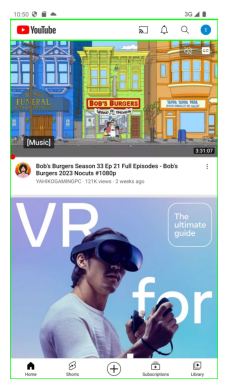

In [46]:
# import cv2, os
# import cv2
# import matplotlib.pyplot as plt

# # Load the image
# image_path = json_path.replace('.json', '.jpeg')
# image = cv2.imread(image_path)
# for i in range(len(best_boxes)):
#     v = {"bounds": {
#                     "left": best_boxes[i].x,
#                     "top": best_boxes[i].y,
#                     "right": best_boxes[i].x + best_boxes[i].width,
#                     "bottom": best_boxes[i].y + best_boxes[i].height
#                     }}
#     x, xw, y, yh = v['bounds']['left'], v['bounds']['right'], v['bounds']['top'], v['bounds']['bottom']
#     w = xw - x
#     h = yh - y
#     print(x, y, w, h, w*h, best_boxes[i].class_name)
#     # y = 1000 - y
#     cv2.rectangle(image, (x, y), (x + w, y + h), (0,255,0), 8)
        

# # Display the image
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.show()

In [1]:
len(dup_bbox)

NameError: name 'dup_bbox' is not defined

In [ ]:
import cv2, os
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = json_path.replace('.json', '.jpeg')
image = cv2.imread(image_path)
# v = {"bounds": {
#                                 "left": 0,
#                                 "top": 805,
#                                 "right": 1440,
#                                 "bottom": 2560
#                               }}
# x, xw, y, yh = v['bounds']['left'], v['bounds']['right'], v['bounds']['top'], v['bounds']['bottom']
# w = xw - x
# h = yh - y
# print(x, y, w, h)
# # y = 1000 - y
# cv2.rectangle(image, (x, y), (x + w, y + h), (0,0,0), 8)
    

# Display the image
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.axis('off')
# plt.show()
for n in range(len(train)):
    # if train[n][0]['index'] == 25:

  
    
    # print(train[n][0]['type'], train[n][1]['type'])
    # if train[n][0]['type'] == 3 and train[n][1]['type'] == 2:
        
        image = cv2.imread(image_path)
        leaf, root, color, _ = train[n]

        v = leaf

        x, xw, y, yh = v['bounds']['left'], v['bounds']['right'], v['bounds']['top'], v['bounds']['bottom']
        w = xw - x
        h = yh - y
        print(v)
        print(x, y, w, h)
        # y = 1000 - y
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 16)

        # v = root
        # x, xw, y, yh = v['bounds']['left'], v['bounds']['right'], v['bounds']['top'], v['bounds']['bottom']
        # w = xw - x
        # h = yh - y
        # print(x, y, w, h)
        # # y = 1000 - y
        # cv2.rectangle(image, (x, y), (x + w, y + h), color, 16)
            

        # Display the image
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
# Assuming you have an image stored in the 'image' variable
# image_path = '/path/to/save/image.jpg'

# # Save the image
# cv2.imwrite(image_path, image)



In [ ]:
from openai import AzureOpenAI
import base64 

api_base = "https://gpt4-yue.openai.azure.com/"
api_key= "8ba630f74c81440689f7e04c5ed0f774"
deployment_name = 'webagent-v'
api_version = '2024-03-01-preview' # this might change in the future

client = AzureOpenAI(
    api_key=api_key,  
    api_version=api_version,
    base_url=f"{api_base}/openai/deployments/{deployment_name}"
)



import base64
from mimetypes import guess_type

# Function to encode a local image into data URL 
def local_image_to_data_url(image_path):
    # Guess the MIME type of the image based on the file extension
    mime_type, _ = guess_type(image_path)
    if mime_type is None:
        mime_type = 'application/octet-stream'  # Default MIME type if none is found

    # Read and encode the image file
    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode('utf-8')

    # Construct the data URL
    return f"data:{mime_type};base64,{base64_encoded_data}"

def call_gpt4v(image_path, image_path2, prompt):
    # Path to your image
    # image_path = "/data3/yue/DocVQA_task1/images/ffbf0023_4.png"


    response = client.chat.completions.create(
        model=deployment_name,
        messages=[
            # { "role": "system", "content": "You are a helpful assistant." },
            { "role": "user", "content": [  
                { 
                    "type": "text", 
                    "text": prompt
                },
                { 
                    "type": "image_url",
                    "image_url": {
                      "url": local_image_to_data_url(image_path)
                    }
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": local_image_to_data_url(image_path2)
                    },
                }
            ] } 
        ],
        max_tokens=2000
    )

    print(response)
    return response

